# MIT Movie Dataset - BERT optimization

This notebook contains the data preparation and model development code for fine-tuning and optimizing the BERT model.

https://huggingface.co/transformers/pretrained_models.html

In [ ]:
import pandas as pd
import numpy as np

# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/My Drive/Colab Notebooks/DAAN888/data')
#os.chdir('/content/drive/My Drive/DAAN888/data')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/DAAN888/data'

In [ ]:
model_dir = '/content/drive/My Drive/Colab Notebooks/DAAN888/models/'

In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/DAAN888/data/'

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Nov 21 11:24:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------



---



## Load Dataset

In [ ]:
import pickle 

with open('mitmovie.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [ ]:
# first row in train set
list(zip(dataset['train_tokens'][0], dataset['train_labels'][0]))

[('what', 'O'),
 ('movies', 'O'),
 ('star', 'O'),
 ('bruce', 'B-ACTOR'),
 ('willis', 'I-ACTOR')]

## Bert Model

Documentation for this model can be found: 
https://huggingface.co/transformers/model_doc/bert.html#overview

Following HuggingFace distilbert tutorial: https://huggingface.co/transformers/custom_datasets.html#tok-ner


In [ ]:
!pip install transformers==3.5.1

     |████████████████████████████████| 1.3MB 13.7MB/s 
     |████████████████████████████████| 2.9MB 45.7MB/s 
     |████████████████████████████████| 890kB 53.7MB/s 
     |████████████████████████████████| 1.1MB 47.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=2bac20a400d795d089cfd13c321be391d43e331b5b70d9b5e7be44099c69094d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import transformers
import torch

print(transformers.__version__)
print(torch.__version__)

3.5.1
1.7.0+cu101


### Train/val split for Optimization Evaluations

In [ ]:
from sklearn.model_selection import train_test_split

train_tokens, val_tokens, train_labels , val_labels = train_test_split(dataset['train_tokens'], dataset['train_labels'], test_size=0.2, random_state=35)

### Encode Labels

In [ ]:
# get the set of unique labels in the movie dataset
uniq_labels = set([label for doc in dataset['train_labels'] for label in doc])

In [ ]:
# assign a number to each label
label_encoding = {label: id for id, label in enumerate(uniq_labels)}
label_encoding

{'B-ACTOR': 18,
 'B-CHARACTER': 12,
 'B-DIRECTOR': 22,
 'B-GENRE': 15,
 'B-PLOT': 8,
 'B-RATING': 19,
 'B-RATINGS_AVERAGE': 4,
 'B-REVIEW': 20,
 'B-SONG': 7,
 'B-TITLE': 0,
 'B-TRAILER': 24,
 'B-YEAR': 13,
 'I-ACTOR': 10,
 'I-CHARACTER': 1,
 'I-DIRECTOR': 16,
 'I-GENRE': 21,
 'I-PLOT': 17,
 'I-RATING': 2,
 'I-RATINGS_AVERAGE': 3,
 'I-REVIEW': 14,
 'I-SONG': 11,
 'I-TITLE': 5,
 'I-TRAILER': 6,
 'I-YEAR': 23,
 'O': 9}

### Encode Texts

To encode the texts, we have to use the same Tokenizer that DistilBert was trained on.

In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')

In [ ]:
print('There are %s words in this tokenizer object' % tokenizer.vocab_size)

There are 30522 words in this tokenizer object


In [ ]:
# use the tokenizer to encode the texts 
train_encodings = tokenizer(train_tokens, 
                            is_split_into_words=True, 
                            return_offsets_mapping=True, 
                            padding=True, 
                            truncation=True)

val_encodings = tokenizer(val_tokens, 
                            is_split_into_words=True, 
                            return_offsets_mapping=True, 
                            padding=True, 
                            truncation=True)

test_encodings = tokenizer(dataset['test_tokens'], 
                           is_split_into_words=True, 
                           return_offsets_mapping=True, 
                           padding=True, 
                           truncation=True)

In [ ]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping'])

In [ ]:
# make sure same number of docs
len(train_encodings['input_ids']), len(dataset['train_tokens'])

(7820, 9775)

In [ ]:
dataset['train_tokens'][0]

['what', 'movies', 'star', 'bruce', 'willis']

In [ ]:
# preview what the encoded result looks like
list(zip(train_encodings['input_ids'][0][0:12], train_encodings['attention_mask'][0][0:12], train_encodings['offset_mapping'][0][0:12]))

[(101, 1, (0, 0)),
 (2265, 1, (0, 4)),
 (2033, 1, (0, 2)),
 (5691, 1, (0, 6)),
 (2055, 1, (0, 5)),
 (1996, 1, (0, 3)),
 (2645, 1, (0, 6)),
 (1997, 1, (0, 2)),
 (1996, 1, (0, 3)),
 (23708, 1, (0, 5)),
 (102, 1, (0, 0)),
 (0, 0, (0, 0))]

In [ ]:
# the model expects all docs to be same length (51) 
# the attention mask will tell the model to ignore the padding with zeros
print('Length of sequences is %s ' % len(train_encodings['input_ids'][1]))

Length of sequences is 44 


In [ ]:
# first document in dataset
print( dataset['train_tokens'][0] )

# check out new tokenization result as words
print( tokenizer.convert_ids_to_tokens( train_encodings['input_ids'][0][0:9]) )

# check out new tokenization result as ids
print( [val for val in train_encodings['input_ids'][0] if val != 0] )

['what', 'movies', 'star', 'bruce', 'willis']
['[CLS]', 'show', 'me', 'movies', 'about', 'the', 'battle', 'of', 'the']
[101, 2265, 2033, 5691, 2055, 1996, 2645, 1997, 1996, 23708, 102]


In [ ]:
find_subwords = []
for i, offset_list in enumerate(train_encodings['offset_mapping']):
  for j, offset_tuple in enumerate(offset_list):
    if offset_tuple[0] != 0:
      find_subwords.append(i)

In [ ]:
np.unique(find_subwords)

array([   1,    7,   12, ..., 7816, 7818, 7819])

In [ ]:
dataset['train_tokens'][1]

['show', 'me', 'films', 'with', 'drew', 'barrymore', 'from', 'the', '1980s']

In [ ]:
list(zip(train_encodings['input_ids'][1][0:12], train_encodings['attention_mask'][1][0:12], train_encodings['offset_mapping'][1][0:12]))

[(101, 1, (0, 0)),
 (2106, 1, (0, 3)),
 (4459, 1, (0, 7)),
 (2079, 1, (0, 2)),
 (12881, 1, (2, 4)),
 (2546, 1, (4, 5)),
 (3622, 1, (0, 6)),
 (2019, 1, (0, 2)),
 (7929, 1, (0, 2)),
 (3185, 1, (0, 5)),
 (1999, 1, (0, 2)),
 (2456, 1, (0, 4))]

In [ ]:
[tokenizer.convert_ids_to_tokens(val) for val in train_encodings['input_ids'][1][0:12]]

['[CLS]',
 'did',
 'stephen',
 'do',
 '##rf',
 '##f',
 'direct',
 'an',
 'ok',
 'movie',
 'in',
 '2000']

### Adjust Labels for Vocab Offset


In the print out above you can see that "barrymore" gets transformed into "barry", "##more". This is because the name is not in the vocabulary of the model, however, those small subwords "barry" and "##more" are. So the offsetting notifies the model of this splitting of the word. However, we have to adjust the labels now to account for this separation. 

Based on https://datascience.stackexchange.com/questions/69640/what-should-be-the-labels-for-subword-tokens-in-bert-for-ner-task we will not drag the label to the new subword feature because that would introduce more instances of that class and change the number of support instances thus making the models difficult to compare. 

Also some comments to consider for an alternative strategy: https://github.com/google-research/bert/issues/646


In [ ]:
import numpy as np

def adjust_labels_for_offset(original_labels, label_dictionary, encodings):

    # convert to the numeric encoding of the label
    labels = [[label_dictionary[label] for label in doc] for doc in original_labels]

    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):

        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)

        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

In [ ]:
train_labels = adjust_labels_for_offset(train_labels, 
                                        label_encoding, 
                                        train_encodings)

val_labels = adjust_labels_for_offset(val_labels, 
                                        label_encoding, 
                                        val_encodings)

test_labels = adjust_labels_for_offset(dataset['test_labels'],
                                      label_encoding, 
                                      test_encodings)

In [ ]:
id_to_label = {id: label for (label,id) in label_encoding.items()}
id_to_label[-100] = 'X'

#print( tokenizer.convert_ids_to_tokens(encoding_example) )
#print([id_to_label[id] for id in train_labels[0][0:9]])
list(zip( tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][0][0:15]), [id_to_label[id] for id in train_labels[0][0:15]], train_labels[0][0:15] )) 

[('[CLS]', 'X', -100),
 ('show', 'O', 9),
 ('me', 'O', 9),
 ('movies', 'O', 9),
 ('about', 'O', 9),
 ('the', 'O', 9),
 ('battle', 'B-PLOT', 8),
 ('of', 'I-PLOT', 17),
 ('the', 'I-PLOT', 17),
 ('bulge', 'I-PLOT', 17),
 ('[SEP]', 'X', -100),
 ('[PAD]', 'X', -100),
 ('[PAD]', 'X', -100),
 ('[PAD]', 'X', -100),
 ('[PAD]', 'X', -100)]

In [ ]:
np.unique(train_labels)

array([-100,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
         21,   22,   23,   24])

### Prepare Pytorch Datasets

https://huggingface.co/transformers/custom_datasets.html#ft-trainer


In [ ]:
import torch

# pytorch is expecting a certain type of dataset 

class pt_dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# remove the offset_mapping
train_encodings.pop("offset_mapping")
val_encodings.pop("offset_mapping")
test_encodings.pop("offset_mapping")

train_dataset = pt_dataset(train_encodings, train_labels)
val_dataset = pt_dataset(val_encodings, val_labels)
test_dataset = pt_dataset(test_encodings, test_labels)

### Train Model

In [ ]:
# https://huggingface.co/blog/ray-tune
#!pip install "ray[tune]"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [ ]:
from transformers import BertForTokenClassification

# load the pretrained model from huggingface
# model = BertForTokenClassification.from_pretrained('bert-large-uncased', num_labels=len(uniq_labels))
# model.to(device);

def model_init():
  model = BertForTokenClassification.from_pretrained('bert-large-uncased', num_labels=len(uniq_labels))
  #model.to(device) # push to gpu
  return model

In [ ]:
#learning_rate (float, optional, defaults to 5e-5) – The initial learning rate for Adam.
#weight_decay (float, optional, defaults to 0) – The weight decay to apply (if not zero).
#adam_epsilon (float, optional, defaults to 1e-8) – Epsilon for the Adam optimizer.

experiments = {'exp_1': 
 {'learning_rate': 5e-5,
'weight_decay': 0.0,
'batch_size': 16},
 
 'exp_2':
 {'learning_rate': 5e-5,
'weight_decay': 0.0,
'batch_size': 32},
 
  'exp_3':
 {'learning_rate': 3e-5,
'weight_decay': 0.0,
'batch_size': 16},
 
 'exp_4':
  {'learning_rate': 3e-5,
'weight_decay': 0.0,
'batch_size': 32},
 
 'exp_5':
 {'learning_rate': 5e-5,
'weight_decay': 0.01,
'batch_size': 16},

 'exp_6':
 {'learning_rate': 5e-5,
'weight_decay': 0.03,
'batch_size': 16}
}

experiments

{'exp_1': {'batch_size': 16, 'learning_rate': 5e-05, 'weight_decay': 0.0},
 'exp_2': {'batch_size': 32, 'learning_rate': 5e-05, 'weight_decay': 0.0},
 'exp_3': {'batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 0.0},
 'exp_4': {'batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 0.0},
 'exp_5': {'batch_size': 16, 'learning_rate': 5e-05, 'weight_decay': 0.01},
 'exp_6': {'batch_size': 16, 'learning_rate': 5e-05, 'weight_decay': 0.03}}

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'bert_lg_unc_opt',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy = 'epoch',
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    logging_dir = model_dir +  'bert_lg_unc_opt/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_f1'
)

In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 5.9MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=9bb85432d8eca76a44fa23401383ac1bd287b5b340beb935e3ca769d6393be90
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
#from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# function for computing monitoring metrics during training

def compute_metrics(p):

        predictions, labels = p
        predictions = np.argmax(predictions, axis=2)

        # Remove ignored index (special tokens)
        true_predictions = [
            [id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [id_to_label[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        preds_stretched = [label for doc in true_predictions for label in doc]
        trues_stretched = [label for doc in true_labels for label in doc]

        return {
            "accuracy_score": accuracy_score(trues_stretched, preds_stretched),
            "precision": precision_score(trues_stretched, preds_stretched, average='macro'),
            "recall": recall_score(trues_stretched, preds_stretched, average='macro'),
            "f1": f1_score(trues_stretched, preds_stretched, average='macro'),
        }



In [ ]:
from datetime import datetime

s = datetime.now()

logger = {}

for experiment in experiments.keys():

    print(iter, experiment)
    
    # update training args for each experiment
    training_args.per_device_train_batch_size = experiments[experiment]['batch_size']
    training_args.learning_rate = experiments[experiment]['learning_rate']
    training_args.weight_decay = experiments[experiment]['weight_decay']  

    trainer = Trainer(
        #model = model,
        model_init = model_init,               # the instantiated 🤗 Transformers model to be trained
        args = training_args,                  # training arguments, defined above
        train_dataset = train_dataset,         # training dataset
        eval_dataset = val_dataset,             # evaluation dataset
        compute_metrics = compute_metrics
    )

    # record the results for each run
    training_results = trainer.train()
    evaluate_results_with_best_epoch = trainer.evaluate()

    logger[experiment] = training_results, evaluate_results_with_best_epoch

print('Time to run experiment:', datetime.now() - s )

<built-in function iter> exp_1


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large

Epoch,Training Loss,Validation Loss,Accuracy Score,Precision,Recall,F1
1,0.323895,0.225493,0.942067,0.837487,0.771170,0.780050
2,0.178143,0.202630,0.946778,0.889801,0.792626,0.800406
3,0.111926,0.198547,0.951338,0.861913,0.800337,0.824867
4,0.101050,0.225124,0.950636,0.870722,0.797526,0.808881
5,0.084479,0.242881,0.948081,0.828830,0.826047,0.824386
6,0.054407,0.255299,0.949233,0.833075,0.823256,0.826354
7,0.018451,0.284117,0.951238,0.837843,0.815796,0.823168
8,0.017560,0.313025,0.949684,0.831415,0.824154,0.825873
9,0.006641,0.337496,0.950486,0.833967,0.825540,0.827439
10,0.006927,0.345268,0.951388,0.840515,0.825373,0.831147


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<built-in function iter> exp_2


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large

Epoch,Training Loss,Validation Loss,Accuracy Score,Precision,Recall,F1
1,0.297452,0.241143,0.938859,0.825671,0.730879,0.751449
2,0.194601,0.219588,0.944923,0.817946,0.765721,0.780083
3,0.119803,0.205278,0.950286,0.849776,0.799222,0.817457
4,0.114865,0.209344,0.950286,0.840563,0.813504,0.819367
5,0.096295,0.229544,0.947379,0.817342,0.831452,0.821495
6,0.053055,0.246762,0.949734,0.833733,0.815394,0.820741
7,0.042783,0.267391,0.948381,0.816205,0.819368,0.814556
8,0.025833,0.284890,0.949033,0.824272,0.826874,0.823750
9,0.009744,0.310677,0.949985,0.829929,0.815108,0.819694
10,0.005936,0.319464,0.949634,0.824129,0.811422,0.815679


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<built-in function iter> exp_3


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large

Epoch,Training Loss,Validation Loss,Accuracy Score,Precision,Recall,F1
1,0.321735,0.219267,0.944172,0.812323,0.773676,0.785200
2,0.177832,0.201463,0.946677,0.841969,0.791134,0.794264
3,0.096289,0.198302,0.953192,0.868224,0.805111,0.826725
4,0.091937,0.211874,0.950286,0.853464,0.814265,0.820932
5,0.067963,0.239728,0.950837,0.838320,0.825230,0.828939
6,0.039014,0.265917,0.948081,0.817814,0.821056,0.817103
7,0.026611,0.282549,0.950486,0.823102,0.818005,0.818397
8,0.014215,0.327480,0.948331,0.819709,0.822511,0.818778
9,0.003436,0.338368,0.949985,0.832827,0.823804,0.825810
10,0.003571,0.347322,0.950887,0.832083,0.823853,0.825739


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<built-in function iter> exp_4


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large

Epoch,Training Loss,Validation Loss,Accuracy Score,Precision,Recall,F1
1,0.348941,0.273418,0.932795,0.724979,0.665199,0.679949
2,0.196021,0.204055,0.946727,0.811886,0.775831,0.786872
3,0.135178,0.186918,0.953493,0.862582,0.812467,0.829489
4,0.111676,0.204287,0.950687,0.864756,0.813899,0.816300
5,0.093512,0.210583,0.952892,0.843305,0.833537,0.833069
6,0.054587,0.224994,0.953293,0.838371,0.835609,0.834201
7,0.050845,0.244694,0.951488,0.835162,0.828244,0.829016
8,0.031506,0.272951,0.946828,0.816936,0.836120,0.824543
9,0.015607,0.288973,0.950035,0.829286,0.833893,0.829938
10,0.013202,0.295447,0.949534,0.828150,0.829009,0.827410


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<built-in function iter> exp_5


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large

Epoch,Training Loss,Validation Loss,Accuracy Score,Precision,Recall,F1
1,0.331747,0.230638,0.941967,0.822284,0.770194,0.783942
2,0.189926,0.212191,0.945024,0.789119,0.771524,0.773397
3,0.118982,0.204423,0.950737,0.854611,0.802377,0.820415
4,0.111200,0.225946,0.947279,0.839039,0.814432,0.811939
5,0.069153,0.243100,0.950286,0.831485,0.822769,0.824093
6,0.042877,0.262331,0.950436,0.840369,0.819262,0.824662
7,0.034375,0.273380,0.950837,0.799412,0.797297,0.796551
8,0.016516,0.309813,0.950837,0.798925,0.794186,0.794637
9,0.004303,0.337248,0.950787,0.834269,0.821498,0.825720
10,0.004242,0.344680,0.950185,0.829483,0.821533,0.824081


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<built-in function iter> exp_6


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large

Epoch,Training Loss,Validation Loss,Accuracy Score,Precision,Recall,F1
1,0.327982,0.216597,0.944272,0.829235,0.774049,0.789685
2,0.180801,0.214804,0.945174,0.805259,0.784876,0.789482
3,0.094916,0.199608,0.953443,0.871918,0.803315,0.826946
4,0.105920,0.212821,0.948882,0.831435,0.813677,0.813724
5,0.087036,0.240823,0.947780,0.818693,0.836713,0.824753
6,0.049921,0.270758,0.948983,0.828944,0.817296,0.819269
7,0.030157,0.285295,0.949484,0.822894,0.817955,0.816331
8,0.019104,0.320017,0.947028,0.814915,0.822463,0.816385
9,0.003339,0.339586,0.950135,0.821224,0.821529,0.819358
10,0.004333,0.345576,0.950286,0.822327,0.820243,0.819676


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time to run experiment: 2:37:57.189774


In [ ]:
import pickle 

# save out the new logged result
if os.path.isfile(model_dir + 'bert_lg_unc_opt/' + 'logger.pickle'):
  print('already exists')
else: 
  with open(model_dir + 'bert_lg_unc_opt/' + 'logger.pickle', 'wb') as handle:
    pickle.dump(logger, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Evaluate Model

In [ ]:
import pickle

with open(model_dir + 'bert_lg_unc_opt/' + 'logger.pickle', 'rb') as handle:
    logger = pickle.load(handle)

In [ ]:
logger

{'exp_1': (TrainOutput(global_step=4890, training_loss=0.14404236963190184),
  {'epoch': 10.0,
   'eval_accuracy_score': 0.9513881928435401,
   'eval_f1': 0.8311467385798627,
   'eval_loss': 0.3452684283256531,
   'eval_precision': 0.8405145526129916,
   'eval_recall': 0.8253727366406342}),
 'exp_2': (TrainOutput(global_step=2450, training_loss=0.1903053750797194),
  {'epoch': 10.0,
   'eval_accuracy_score': 0.9490327753833818,
   'eval_f1': 0.8237499024145633,
   'eval_loss': 0.2848895490169525,
   'eval_precision': 0.8242719891157327,
   'eval_recall': 0.8268738730942303}),
 'exp_3': (TrainOutput(global_step=4890, training_loss=0.1494842217256199),
  {'epoch': 10.0,
   'eval_accuracy_score': 0.9508369249273328,
   'eval_f1': 0.8289390969814473,
   'eval_loss': 0.23972761631011963,
   'eval_precision': 0.838320274067069,
   'eval_recall': 0.8252303118421725}),
 'exp_4': (TrainOutput(global_step=2450, training_loss=0.21252379125478316),
  {'epoch': 10.0,
   'eval_accuracy_score': 0.953

In [ ]:
losses = []
for key in logger.keys():
   losses.append( (key, 
                   experiments[key]['batch_size'],
                   experiments[key]['learning_rate'],
                   experiments[key]['weight_decay'],
                   logger[key][1]['eval_f1'] 
                   ) 
   )

losses

[('exp_1', 16, 5e-05, 0.0, 0.8311467385798627),
 ('exp_2', 32, 5e-05, 0.0, 0.8237499024145633),
 ('exp_3', 16, 3e-05, 0.0, 0.8289390969814473),
 ('exp_4', 32, 3e-05, 0.0, 0.8342013852755817),
 ('exp_5', 16, 5e-05, 0.01, 0.8257198368882374),
 ('exp_6', 16, 5e-05, 0.03, 0.8269461538835218)]

In [ ]:
# [('iter1', 'exp_1', 16, 5e-05, 0.0, 0.7914281533710809),
#  ('iter1', 'exp_2', 32, 5e-05, 0.0, 0.7887348669681818),
#  ('iter1', 'exp_3', 16, 3e-05, 0.0, 0.7922037083463254),
#  ('iter1', 'exp_4', 32, 3e-05, 0.0, 0.7894251544273335),
#  ('iter1', 'exp_5', 16, 5e-05, 0.01, 0.7953532231428433),
#  ('iter1', 'exp_6', 16, 5e-05, 0.03, 0.8013170476909508),
#  ('iter2', 'exp_1', 16, 5e-05, 0.0, 0.7914281533710809),
#  ('iter2', 'exp_2', 32, 5e-05, 0.0, 0.7887348669681818),
#  ('iter2', 'exp_3', 16, 3e-05, 0.0, 0.7922037083463254),
#  ('iter2', 'exp_4', 32, 3e-05, 0.0, 0.7894251544273335),
#  ('iter2', 'exp_5', 16, 5e-05, 0.01, 0.7953532231428433),
#  ('iter2', 'exp_6', 16, 5e-05, 0.03, 0.8013170476909508),
#  ('iter3', 'exp_1', 16, 5e-05, 0.0, 0.7914281533710809),
#  ('iter3', 'exp_2', 32, 5e-05, 0.0, 0.7887348669681818),
#  ('iter3', 'exp_3', 16, 3e-05, 0.0, 0.7922037083463254),
#  ('iter3', 'exp_4', 32, 3e-05, 0.0, 0.7894251544273335),
#  ('iter3', 'exp_5', 16, 5e-05, 0.01, 0.7953532231428433),
#  ('iter3', 'exp_6', 16, 5e-05, 0.03, 0.8013170476909508)]

In [ ]:
loss_df = pd.DataFrame(losses, columns = ['Experiment', 'Batch Size', 'Learning Rate', 'Weight Decay', 'F1-score'])
loss_df

,Experiment,Batch Size,Learning Rate,Weight Decay,F1-score
0,exp_1,16,0.00005,0.00,0.831147
1,exp_2,32,0.00005,0.00,0.823750
2,exp_3,16,0.00003,0.00,0.828939
3,exp_4,32,0.00003,0.00,0.834201
4,exp_5,16,0.00005,0.01,0.825720
5,exp_6,16,0.00005,0.03,0.826946


In [ ]:
# loss_df_mean = loss_df.groupby('Experiment').mean()
# loss_df_mean.reset_index(inplace=True)
# loss_df_mean

In [ ]:
loss_df.to_csv(model_dir + 'bert_lg_unc_opt/' + 'metrics_df.csv', index=False)

In [ ]:
np.argmax(loss_df['F1-score']) +1

4

In [ ]:
loss_df['Experiment_num'] = list(range(1,7))
loss_df = loss_df[['Experiment_num', 'Batch Size', 'Learning Rate', 'Weight Decay', 'F1-score']]

In [ ]:
loss_df['Experiment_num']

0    1
1    2
2    3
3    4
4    5
5    6
Name: Experiment_num, dtype: int64

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = loss_df['Experiment_num'],
                   colorscale =  'portland', #[[0,'purple'],[0.5,'lightseagreen'],[1,'gold'], [0,'red'], [0.5, 'aqua'], [0.5, 'blue']],
                 showscale = True,
                 ),
        dimensions = list([
            dict(range = [1,6],
                label ='Experiment Num', values = loss_df['Experiment_num']),
            dict(range = [0,48],
                label ='Batch Size', values = loss_df['Batch Size']),
            dict(range = [0,5e-5],
                label = 'Learning Rate', values = loss_df['Learning Rate']),
            dict(range = [0,0.05],
                label = 'Weight Decay', values = loss_df['Weight Decay']),
            dict(range = [0.82,0.835],
                label = 'F1-score', values = loss_df['F1-score'])
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    width=800
)

fig.show()

In [ ]:
experiments

{'exp_1': {'batch_size': 16, 'learning_rate': 5e-05, 'weight_decay': 0.0},
 'exp_2': {'batch_size': 32, 'learning_rate': 5e-05, 'weight_decay': 0.0},
 'exp_3': {'batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 0.0},
 'exp_4': {'batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 0.0},
 'exp_5': {'batch_size': 16, 'learning_rate': 5e-05, 'weight_decay': 0.01},
 'exp_6': {'batch_size': 16, 'learning_rate': 5e-05, 'weight_decay': 0.03}}

In [ ]:
exp_4 = pd.read_csv(model_dir + 'bert_lg_unc_opt/' + 'Exp_4_results.csv')
exp_4

,Epoch,Training Loss,Validation Loss,Accuracy Score,Precision,Recall,F1
0,1,0.348941,0.273418,0.932795,0.724979,0.665199,0.679949
1,2,0.196021,0.204055,0.946727,0.811886,0.775831,0.786872
2,3,0.135178,0.186918,0.953493,0.862582,0.812467,0.829489
3,4,0.111676,0.204287,0.950687,0.864756,0.813899,0.816300
4,5,0.093512,0.210583,0.952892,0.843305,0.833537,0.833069
5,6,0.054587,0.224994,0.953293,0.838371,0.835609,0.834201
6,7,0.050845,0.244694,0.951488,0.835162,0.828244,0.829016
7,8,0.031506,0.272951,0.946828,0.816936,0.836120,0.824543
8,9,0.015607,0.288973,0.950035,0.829286,0.833893,0.829938
9,10,0.013202,0.295447,0.949534,0.828150,0.829009,0.827410


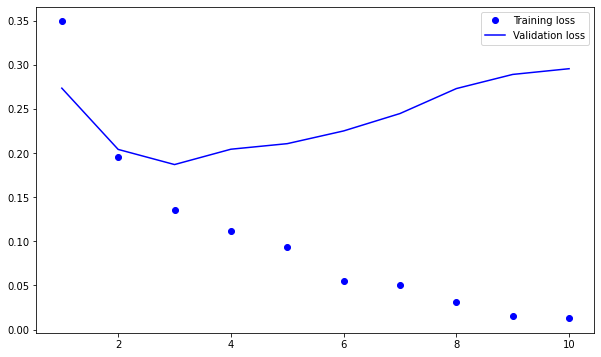

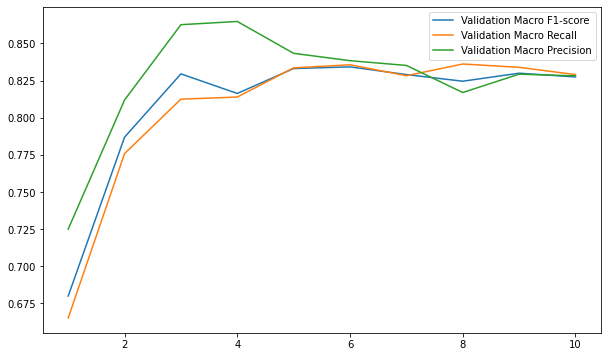

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(exp_4.Epoch, exp_4['Training Loss'], 'bo', label='Training loss')
plt.plot(exp_4.Epoch, exp_4['Validation Loss'], 'b', label='Validation loss')
plt.legend()

plt.figure(figsize=(10,6))
plt.plot(exp_4.Epoch, exp_4['F1'],  label='Validation Macro F1-score')
plt.plot(exp_4.Epoch, exp_4['Recall'],  label='Validation Macro Recall')
plt.plot(exp_4.Epoch, exp_4['Precision'],  label='Validation Macro Precision')
#plt.plot(exp_4.Epoch, exp_4['Accuracy Score'],  label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
#  ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
#              'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
#              'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
#              'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
#              'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
#              'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
#              'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
#              'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
#              'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
#              'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
#              'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
#              'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
#              'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
#              'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']

## Continual Pretraining (Masked language model)

Guidance for masked language modeling is taken directly from huggingface examples: 
https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/language_modeling.ipynb#scrollTo=nRZ-5v_P3l_b

In [ ]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 1.3MB 8.0MB/s 
     |████████████████████████████████| 890kB 29.4MB/s 
     |████████████████████████████████| 2.9MB 63.1MB/s 
     |████████████████████████████████| 1.1MB 50.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=fbc0a8fdd6bdb5b154efd4a6da341f5c6324a63aaa15395c0bde77836e19ccb2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 153kB 9.0MB/s 
     |████████████████████████████████| 17.7MB 176kB/s 
     |████████████████████████████████| 245kB 56.4MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [ ]:
import transformers
import torch

print(transformers.__version__)
print(torch.__version__)

3.4.0
1.7.0+cu101


In [ ]:
model_name = 'distilbert-base-uncased' # 'bert-large-uncased'

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [ ]:
tokenizer.model_max_length, tokenizer.mask_token

(512, '[MASK]')

In [ ]:
def tokenize_function(examples):

  for k in examples.keys():
    if 'train' in k:
      encodings = tokenizer(examples['train_tokens'], 
                                is_split_into_words = True, 
                                return_offsets_mapping = False, 
                                padding = True, 
                                truncation = True,
                                return_token_type_ids = False)
    if 'test' in k:
      encodings = tokenizer(examples['test_tokens'], 
                                is_split_into_words = True, 
                                return_offsets_mapping = False, 
                                padding = True, 
                                truncation = True,
                                return_token_type_ids = False)
  return encodings

In [ ]:
from datasets import Dataset

hf_train = Dataset.from_dict({k:v for k,v in dataset.items() if 'train' in k})
hf_test = Dataset.from_dict({k:v for k,v in dataset.items() if 'test' in k})

In [ ]:
train_encodings = hf_train.map(tokenize_function, batched=True, num_proc=4, remove_columns=["train_tokens", 'train_labels'])
test_encodings = hf_test.map(tokenize_function, batched=True, num_proc=4, remove_columns=["test_tokens", 'test_labels'])

In [ ]:
train_encodings.column_names

['attention_mask', 'input_ids']

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
block_size = 32

In [ ]:
lm_train = train_encodings.map(
    group_texts,
    batched = True,
    batch_size = 1000,
    num_proc=4,
)

lm_test = test_encodings.map(
    group_texts,
    batched = True,
    batch_size = 1000,
    num_proc=4,
)

In [ ]:
lm_train[1]

In [ ]:
from transformers import AutoModelForMaskedLM

model = AutoModelForMaskedLM.from_pretrained(model_name)

In [ ]:
model.to('cuda');

In [ ]:
from transformers import DataCollatorForLanguageModeling

# set masking probability to 15%
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'distbert_unc_opt/maskedlm',          # output directory
    overwrite_output_dir = True,
    #evaluation_strategy = 'epoch',
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size = 16,  # batch size per device during training
    #per_device_eval_batch_size = 1,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    logging_dir = model_dir +  'distbert_unc_opt/maskedlm/logs',            # directory for storing logs
    logging_steps=10,
    #load_best_model_at_end = True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = lm_train,
    eval_dataset = lm_test,
    data_collator = data_collator,
)

In [ ]:
trainer.train()

Step,Training Loss
10,5.189795
20,5.553507
30,5.388803
40,5.292232
50,4.491350
60,4.333548
70,4.157007
80,4.482080
90,3.730078
100,3.765933


TrainOutput(global_step=1884, training_loss=2.4873440817409764)

In [ ]:
#trainer.evaluate()

NameError: ignored

## DistilBert Model

Documentation for this model can be found: 
https://huggingface.co/transformers/model_doc/distilbert.html

More model details here: https://github.com/huggingface/transformers/tree/master/examples/distillation

Following HuggingFace distilbert tutorial: https://huggingface.co/transformers/custom_datasets.html#tok-ner


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 2.8MB/s 
     |████████████████████████████████| 2.9MB 12.8MB/s 
     |████████████████████████████████| 890kB 31.1MB/s 
     |████████████████████████████████| 1.1MB 44.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=415241f8dcec877e539e214460c0a44bfc693f5bab977376d27359c4e1e966de
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import transformers
transformers.__version__

'3.4.0'

In [ ]:
import torch
torch.__version__

'1.7.0+cu101'

### Encode Labels

In [ ]:
# get the set of unique labels in the movie dataset
uniq_labels = set([label for doc in dataset['train_labels'] for label in doc])

In [ ]:
# assign a number to each label
label_encoding = {label: id for id, label in enumerate(uniq_labels)}
label_encoding

{'B-ACTOR': 20,
 'B-CHARACTER': 8,
 'B-DIRECTOR': 15,
 'B-GENRE': 2,
 'B-PLOT': 11,
 'B-RATING': 9,
 'B-RATINGS_AVERAGE': 1,
 'B-REVIEW': 12,
 'B-SONG': 3,
 'B-TITLE': 10,
 'B-TRAILER': 14,
 'B-YEAR': 0,
 'I-ACTOR': 17,
 'I-CHARACTER': 18,
 'I-DIRECTOR': 21,
 'I-GENRE': 5,
 'I-PLOT': 16,
 'I-RATING': 13,
 'I-RATINGS_AVERAGE': 7,
 'I-REVIEW': 19,
 'I-SONG': 23,
 'I-TITLE': 24,
 'I-TRAILER': 4,
 'I-YEAR': 6,
 'O': 22}

### Encode Texts

To encode the texts, we have to use the same Tokenizer that DistilBert was trained on.

In [ ]:
from transformers import DistilBertTokenizerFast

# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
print('There are %s words in this tokenizer object' % tokenizer.vocab_size)

There are 30522 words in this tokenizer object


In [ ]:
# use the tokenizer to encode the texts 
train_encodings = tokenizer(dataset['train_tokens'], 
                            is_split_into_words=True, 
                            return_offsets_mapping=True, 
                            padding=True, 
                            truncation=True)

test_encodings = tokenizer(dataset['test_tokens'], 
                           is_split_into_words=True, 
                           return_offsets_mapping=True, 
                           padding=True, 
                           truncation=True)

In [ ]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping'])

In [ ]:
# make sure same number of docs
len(train_encodings['input_ids']), len(dataset['train_tokens'])

(9775, 9775)

In [ ]:
dataset['train_tokens'][0]

['what', 'movies', 'star', 'bruce', 'willis']

In [ ]:
# preview what the encoded result looks like
list(zip(train_encodings['input_ids'][0][0:12], train_encodings['attention_mask'][0][0:12], train_encodings['offset_mapping'][0][0:12]))

[(101, 1, (0, 0)),
 (2054, 1, (0, 4)),
 (5691, 1, (0, 6)),
 (2732, 1, (0, 4)),
 (5503, 1, (0, 5)),
 (12688, 1, (0, 6)),
 (102, 1, (0, 0)),
 (0, 0, (0, 0)),
 (0, 0, (0, 0)),
 (0, 0, (0, 0)),
 (0, 0, (0, 0)),
 (0, 0, (0, 0))]

In [ ]:
# the model expects all docs to be same length (51) 
# the attention mask will tell the model to ignore the padding with zeros
print('Length of sequences is %s ' % len(train_encodings['input_ids'][0]))

Length of sequences is 51 


In [ ]:
doc = 1

# first document in dataset
print( dataset['train_tokens'][doc] )

print()

# check out new tokenization result as words
print( tokenizer.convert_ids_to_tokens( train_encodings['input_ids'][doc][0:13]) )

# check out new tokenization result as ids
print( train_encodings['input_ids'][doc][0:13] )

# check out attentions
print( train_encodings['attention_mask'][doc][0:13] )

# check out offsets
print( train_encodings['offset_mapping'][doc][0:13] )

['show', 'me', 'films', 'with', 'drew', 'barrymore', 'from', 'the', '1980s']

['[CLS]', 'show', 'me', 'films', 'with', 'drew', 'barry', '##more', 'from', 'the', '1980s', '[SEP]', '[PAD]']
[101, 2265, 2033, 3152, 2007, 3881, 6287, 5974, 2013, 1996, 3865, 102, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[(0, 0), (0, 4), (0, 2), (0, 5), (0, 4), (0, 4), (0, 5), (5, 9), (0, 4), (0, 3), (0, 5), (0, 0), (0, 0)]


In [ ]:
find_subwords = []
for i, offset_list in enumerate(train_encodings['offset_mapping']):
  for j, offset_tuple in enumerate(offset_list):
    if offset_tuple[0] != 0:
      find_subwords.append(i)

In [ ]:
np.unique(find_subwords)

array([   1,    2,    3, ..., 9752, 9767, 9772])

In [ ]:
dataset['train_tokens'][1]

['show', 'me', 'films', 'with', 'drew', 'barrymore', 'from', 'the', '1980s']

In [ ]:
list(zip(train_encodings['input_ids'][1][0:12], train_encodings['attention_mask'][1][0:12], train_encodings['offset_mapping'][1][0:12]))

[(101, 1, (0, 0)),
 (2265, 1, (0, 4)),
 (2033, 1, (0, 2)),
 (3152, 1, (0, 5)),
 (2007, 1, (0, 4)),
 (3881, 1, (0, 4)),
 (6287, 1, (0, 5)),
 (5974, 1, (5, 9)),
 (2013, 1, (0, 4)),
 (1996, 1, (0, 3)),
 (3865, 1, (0, 5)),
 (102, 1, (0, 0))]

### Adjust Labels for Vocab Offset


In the print out above you can see that "barrymore" gets transformed into "barry##", "##more". This is because the name is not in the vocabulary of the model, however, those small subwords "barry##" and "##more" are. So the offsetting notifies the model of this splitting of the word. However, we have to adjust the labels now to account for this separation. 

Based on https://datascience.stackexchange.com/questions/69640/what-should-be-the-labels-for-subword-tokens-in-bert-for-ner-task we will not drag the label to the new subword feature because that would introduce more instances of that class and change the number of support instances thus making the models difficult to compare. 

Also some comments to consider for an alternative strategy: https://github.com/google-research/bert/issues/646


In [ ]:
import numpy as np

def adjust_labels_for_offset(original_labels, label_dictionary, encodings):

    # convert to the numeric encoding of the label
    labels = [[label_dictionary[label] for label in doc] for doc in original_labels]

    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):

        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)

        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

In [ ]:
train_labels = adjust_labels_for_offset(dataset['train_labels'], 
                                        label_encoding, 
                                        train_encodings)

test_labels = adjust_labels_for_offset(dataset['test_labels'],
                                      label_encoding, 
                                      test_encodings)

In [ ]:
id_to_label = {id: label for (label,id) in label_encoding.items()}
id_to_label[-100] = 'X'

#print( tokenizer.convert_ids_to_tokens(encoding_example) )
#print([id_to_label[id] for id in train_labels[0][0:9]])
list(zip( tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][0][0:15]), [id_to_label[id] for id in train_labels[0][0:15]], train_labels[0][0:15] )) 

[('[CLS]', 'X', -100),
 ('what', 'O', 22),
 ('movies', 'O', 22),
 ('star', 'O', 22),
 ('bruce', 'B-ACTOR', 20),
 ('willis', 'I-ACTOR', 17),
 ('[SEP]', 'X', -100),
 ('[PAD]', 'X', -100),
 ('[PAD]', 'X', -100),
 ('[PAD]', 'X', -100),
 ('[PAD]', 'X', -100),
 ('[PAD]', 'X', -100),
 ('[PAD]', 'X', -100),
 ('[PAD]', 'X', -100),
 ('[PAD]', 'X', -100)]

In [ ]:
np.unique(train_labels)

array([-100,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
         21,   22,   23,   24])

### Prepare Pytorch Datasets

https://huggingface.co/transformers/custom_datasets.html#ft-trainer


In [ ]:
import torch

# pytorch is expecting a certain type of dataset 

class pt_dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# remove the offset_mapping
train_encodings.pop("offset_mapping") 
test_encodings.pop("offset_mapping")

train_dataset = pt_dataset(train_encodings, train_labels)
test_dataset = pt_dataset(test_encodings, test_labels)

### Train Model

In [ ]:
from transformers import DistilBertForTokenClassification

# load the pretrained model from huggingface
#model = DistilBertForTokenClassification.from_pretrained('distilbert-base-cased', num_labels=len(uniq_labels))
model = DistilBertForTokenClassification.from_pretrained(model_dir + 'distbert_unc_opt/maskedlm/checkpoint-1500', num_labels=len(uniq_labels))

# def model_init():
#   model = DistilBertForTokenClassification.from_pretrained(model_dir + 'distbert_unc_opt/maskedlm/checkpoint-1500', num_labels=len(uniq_labels))
#   #model.to(device) # push to gpu
#   return model

Some weights of the model checkpoint at /content/drive/My Drive/Colab Notebooks/DAAN888/models/distbert_unc_opt/maskedlm/checkpoint-1500 were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at /content/drive/My Drive/Colab Notebooks/DAAN88

In [ ]:
from transformers import Trainer, TrainingArguments

# https://huggingface.co/transformers/main_classes/trainer.html
# boiler plate code from huggingface to launch a trainer instance
# sets directories and baseline configuration for batch sizes and weight decay

training_args = TrainingArguments(
    output_dir =  model_dir +  'distbert_unc_opt',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs = 3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'distbert_unc_opt/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    #model_init = model_init,
    args = training_args,                  # training arguments, defined above
    train_dataset = train_dataset,         # training dataset
    eval_dataset = test_dataset             # evaluation dataset
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.264032,0.288429
2,0.254114,0.242522
3,0.120575,0.243338


TrainOutput(global_step=1833, training_loss=0.3425212387692649)

In [ ]:
trainer.evaluate()

{'epoch': 3.0, 'eval_loss': 0.2425217628479004, 'total_flos': 595676500112250}

In [ ]:
#trainer.save_model(model_dir +  'distbert_unc_opt')

In [ ]:
# import os

#os.makedirs(model_dir + 'distilbert_testing')

# torch.save(model.state_dict(), model_dir + 'distbert_unc_opt/model.pth')
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(model_dir + 'distbert_unc_opt')
# tokenizer.save_pretrained(model_dir + 'distbert_unc_opt')
#model.save_pretrained(model_dir + 'distilbert_testing')

### Evaluate Model

In [ ]:
from transformers import DistilBertForTokenClassification, DistilBertConfig, AutoModelForTokenClassification

#dir = model_dir + 'distbert_unc_opt'
# retreive the saved model 
model = DistilBertForTokenClassification.from_pretrained(pretrained_model_name_or_path = model_dir + 'distbert_unc_opt/checkpoint-1833')

In [ ]:
#model.load_state_dict(torch.load(model_dir + 'distbert_unc_opt'/model.pth', map_location='cpu'))

In [ ]:
model.eval();

In [ ]:
input_ids = torch.tensor([test_encodings['input_ids'][0]])

In [ ]:
with torch.no_grad():
    output = model(input_ids)

label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [ ]:
[id_to_label[label] for label in label_indices.tolist()[0]][0:10], dataset['test_labels'][0]

(['B-PLOT',
  'B-PLOT',
  'B-PLOT',
  'B-PLOT',
  'B-PLOT',
  'I-REVIEW',
  'I-ACTOR',
  'B-PLOT',
  'B-PLOT',
  'B-PLOT'],
 ['O', 'O', 'O', 'O', 'B-GENRE', 'I-GENRE', 'O', 'B-YEAR', 'I-YEAR'])

In [ ]:
# from transformers import Trainer, TrainingArguments

# training_args = TrainingArguments(
#     output_dir = model_dir +  'distbert_unc_opt',          # output directory
#     #overwrite_output_dir = True,
#     evaluation_strategy='epoch',
#     num_train_epochs=3,              # total number of training epochs
#     per_device_train_batch_size=16,  # batch size per device during training
#     per_device_eval_batch_size=64,   # batch size for evaluation
#     warmup_steps=500,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_dir = model_dir +  'distbert_unc_opt/logs',            # directory for storing logs
#     logging_steps=10,
# )

# trainer = Trainer(
#     model=model,                         
#     args=training_args,                  # training arguments, defined above
#     train_dataset = train_dataset,         # training dataset
#     eval_dataset = test_dataset             # evaluation dataset
# )

In [ ]:
# last layer output/activation has the shape of (batch_size, seq_len,num_of_labels)
output, label_ids, metrics = trainer.predict(test_dataset)

In [ ]:
metrics

{'eval_loss': 0.2425217628479004}

In [ ]:
# convert output which is logits to index of max logit
preds = np.argmax(output, axis=2)
preds.shape

(2443, 43)

In [ ]:
# https://medium.com/analytics-vidhya/named-entity-recognition-for-turkish-with-bert-f8ec04a31b0
# this function formats the predictions by removing the padding
# so that we can line it up directly with original data

batch_size, seq_len = preds.shape

# list of token-level predictions shape = (batch_size, seq_len)
preds_list = [[] for _ in range(batch_size)]
for i in range(batch_size):
  for j in range(seq_len):
    # ignore pad_tokens
    if label_ids[i, j] != -100: # torch.nn.CrossEntropyLoss().ignore_index:
      preds_list[i].append(id_to_label[preds[i][j]])

In [ ]:
# you can see the number of predicted values and the actual values for a 
# given doc is the same, implying that the predictions line up
# to the actuals because we set labels to -100 for [cls], [sep], and ## subwords
len(preds_list[6]), len(dataset['test_tokens'][6])

(13, 13)

In [ ]:
preds_stretched = [label for doc in preds_list for label in doc]
trues_stretched = [label for doc in dataset['test_labels'] for label in doc]

In [ ]:
from sklearn.metrics import classification_report

f = open(model_dir + 'distbert_unc_opt'  + '/class_report_test.txt', 'w') 

class_report = classification_report(trues_stretched, preds_stretched)
print(class_report, file=f ) 

f.close()

print(class_report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.93      0.95      0.94       812
      B-CHARACTER       0.72      0.63      0.67        90
       B-DIRECTOR       0.92      0.88      0.90       456
          B-GENRE       0.96      0.95      0.95      1117
           B-PLOT       0.80      0.75      0.77       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.95      0.92      0.93       451
         B-REVIEW       0.41      0.16      0.23        56
           B-SONG       0.76      0.72      0.74        54
          B-TITLE       0.88      0.92      0.90       562
        B-TRAILER       0.82      0.90      0.86        30
           B-YEAR       0.95      0.95      0.95       720
          I-ACTOR       0.92      0.94      0.93       862
      I-CHARACTER       0.69      0.53      0.60        75
       I-DIRECTOR       0.93      0.87      0.90       496
          I-GENRE       0.90      0.73      0.81       

In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 2.9MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=a035decb201f7e9a3728a362c5c7716bb4841b682a4b2b68a46988fb662c3a61
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import classification_report as classification_report_seqeval

f = open(model_dir + 'distbert_unc_opt'  + '/seq_class_report_test.txt', 'w') 

seq_class_report = classification_report_seqeval(dataset['test_labels'], preds_list)
print(seq_class_report, file=f ) 

f.close() 
print(seq_class_report)

                 precision    recall  f1-score   support

          ACTOR       0.91      0.93      0.92       812
      CHARACTER       0.64      0.60      0.62        90
       DIRECTOR       0.91      0.88      0.89       456
          GENRE       0.93      0.93      0.93      1117
           PLOT       0.72      0.74      0.73       491
         RATING       0.94      0.93      0.93       500
RATINGS_AVERAGE       0.86      0.88      0.87       451
         REVIEW       0.18      0.07      0.10        56
           SONG       0.62      0.61      0.62        54
          TITLE       0.84      0.90      0.87       562
        TRAILER       0.82      0.90      0.86        30
           YEAR       0.95      0.94      0.94       720

      micro avg       0.88      0.88      0.88      5339
      macro avg       0.78      0.78      0.77      5339
   weighted avg       0.88      0.88      0.88      5339

